In [ ]:
import autograd.numpy as np
import pandas as pd
from google.colab import drive
from autograd import grad
import matplotlib.pyplot as plt

drive.mount('/content/drive', force_remount=True)
%matplotlib inline

# datapath to data (all data is stored inside default google colab "content" directory)
datapath = '/content/drive/MyDrive/mlrefined_datasets/nonlinear_superlearn_datasets/'

Mounted at /content/drive


# Exercise 11.7. Bagging two-class classification models

In [ ]:
csvname = datapath + 'new_circle_data.csv'

data = np.loadtxt(csvname, delimiter=',')
x = data[:-1, :]
y = data[-1, :]

P = x.shape[1]

# assume labels are -1/+1 -> convert to 0/1
y_bin = (y > 0).astype(int)

def poly_map(x, degree):
    x1 = x[0, :]
    x2 = x[1, :]
    features = []

    for d in range(degree + 1):
        for i in range(d + 1):
            j = d - i
            features.append((x1 ** i) * (x2 ** j))

    phi = np.vstack(features)
    return phi

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def logistic_train(phi, y, num_steps=5000, step_size=0.1):
    D, N = phi.shape
    w = np.zeros(D)

    for t in range(num_steps):
        z = np.dot(w, phi)
        yhat = sigmoid(z)
        grad = np.dot(phi, (yhat - y)) / N
        w -= step_size * grad

    return w

def logistic_predict(phi, w):
    z = np.dot(w, phi)
    yhat = sigmoid(z)
    return (yhat > 0.5).astype(int)

def train_cv_poly_model(x, y, degrees=range(1, 9), train_frac=2/3, seed=None):
    rng = np.random.RandomState(seed)
    index = np.arange(x.shape[1])
    rng.shuffle(index)

    train_size = int(train_frac * len(index))
    train_index = index[:train_size]
    val_index = index[train_size:]

    x_train = x[:, train_index]
    x_val = x[:, val_index]
    y_train = y[train_index]
    y_val = y[val_index]

    best_deg = None
    best_val_err = np.inf
    best_w = None

    for d in degrees:
        phi_train = poly_map(x_train, d)
        phi_val   = poly_map(x_val, d)

        w = logistic_train(phi_train, y_train,
                           num_steps=3000, step_size=0.1)

        val_pred = logistic_predict(phi_val, w)
        val_err = np.mean(val_pred != y_val)

        if val_err < best_val_err:
            best_val_err = val_err
            best_deg = d
            best_w = w

    return {
        "degree": best_deg,
        "val_error": best_val_err,
        "w": best_w,
        "train_index": train_index,
        "val_index": val_index
    }

num_models = 5
models = []

for m in range(num_models):
    model = train_cv_poly_model(x, y_bin, seed=m)
    models.append(model)

    # misclassifications on full dataset for this model
    phi_full = poly_map(x, model["degree"])
    preds_full = logistic_predict(phi_full, model["w"])
    miscls = np.sum(preds_full != y_bin)

    print(f"Model {m+1}: degree {model['degree']}, "
          f"val error = {model['val_error']:.3f}, "
          f"misclassifications on full data = {miscls}/{P}")

all_preds = []

for model in models:
    phi_full = poly_map(x, model["degree"])
    preds_full = logistic_predict(phi_full, model["w"])
    all_preds.append(preds_full)

all_preds = np.array(all_preds)   # shape (5, P)

votes = np.sum(all_preds, axis=0)  # number of "1" votes per point
bag_pred = (votes >= (num_models / 2)).astype(int)

bag_miscls = np.sum(bag_pred != y_bin)
print(f"\nBagged model misclassifications = {bag_miscls}/{P}")



Model 1: degree 2, val error = 0.152, misclassifications on full data = 12/99
Model 2: degree 2, val error = 0.091, misclassifications on full data = 5/99
Model 3: degree 4, val error = 0.121, misclassifications on full data = 10/99
Model 4: degree 4, val error = 0.152, misclassifications on full data = 11/99
Model 5: degree 4, val error = 0.152, misclassifications on full data = 11/99

Bagged model misclassifications = 11/99


# Exercise 12.8. Multi-class classification with the RBF kernel

x shape: (2, 89)
y shape: (1, 89)
num classes: 3
gamma = 0.01: final misclassified = 35 / 89
gamma = 0.1: final misclassified = 35 / 89
gamma = 100.0: final misclassified = 25 / 89


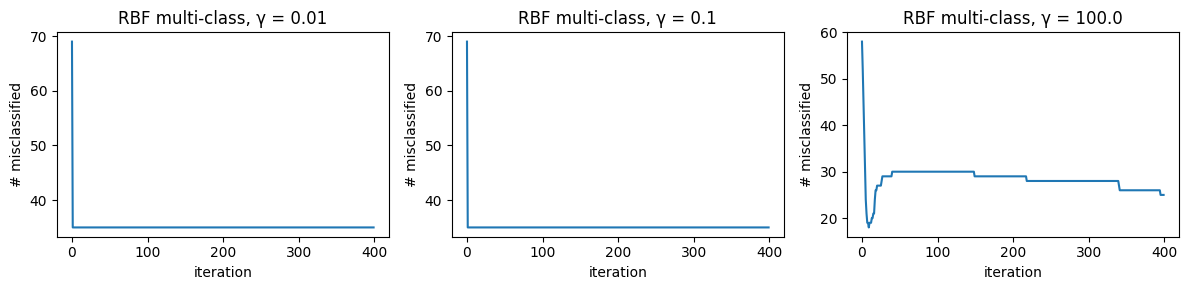

In [ ]:
csvname = datapath + '2eggs_multiclass.csv'
data = np.loadtxt(csvname, delimiter=',')

x = data[:-1, :]
y = data[-1:, :]

print("x shape:", x.shape)
print("y shape:", y.shape)

P = x.shape[1]

# flatten labels and map to 0,...,C-1
y_flat = y.flatten()
classes, y_int = np.unique(y_flat, return_inverse=True)
C = len(classes)
print("num classes:", C)

def rbf_kernel(x, gamma):
    X = x.T
    sq_norms = np.sum(X**2, axis=1, keepdims=True)
    dist2 = sq_norms + sq_norms.T - 2 * X @ X.T
    K = np.exp(-gamma * dist2)
    return K

def softmax(scores):
    scores = scores - np.max(scores, axis=1, keepdims=True)  # stability
    exp_scores = np.exp(scores)
    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

def cross_entropy_loss(scores, y_int):
    scores = scores - np.max(scores, axis=1, keepdims=True)  # stability
    exp_scores = np.exp(scores)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    log_probs = -np.log(probs[np.arange(len(y_int)), y_int])
    return np.mean(log_probs)

def train_rbf_softmax(x, y_int, gamma, num_iters=400):
    P = x.shape[1]
    C = np.max(y_int) + 1

    # kernel matrix (features)
    K = rbf_kernel(x, gamma)

    rng = np.random.RandomState(0)
    W = 0.01 * rng.randn(P, C)
    b = np.zeros(C)

    # one-hot labels
    Y_onehot = np.zeros((P, C))
    Y_onehot[np.arange(P), y_int] = 1

    # step size
    if gamma > 1.0:
        step_size = 0.01
    else:
        step_size = 0.05

    mis_hist = []
    loss_hist = []

    for t in range(num_iters):
        # forward
        scores = K @ W + b
        probs = softmax(scores)

        # misclassification
        preds = np.argmax(scores, axis=1)
        mis = np.sum(preds != y_int)
        mis_hist.append(mis)

        # gradient
        diff = probs - Y_onehot
        grad_W = (K.T @ diff) / P
        grad_b = np.mean(diff, axis=0)

        # update
        W -= step_size * grad_W
        b -= step_size * grad_b

    return W, b, K, np.array(mis_hist), np.array(loss_hist)

gammas = [1e-2, 1e-1, 100.0]
histories = {}

for gamma in gammas:
    W, b, K, mis_hist, loss_hist = train_rbf_softmax(
        x, y_int, gamma, num_iters=400
    )
    histories[gamma] = (W, b, K, mis_hist, loss_hist)
    print(f"gamma = {gamma}: final misclassified = {mis_hist[-1]} / {P}")

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for i, gamma in enumerate(gammas):
    _, _, _, mis_hist, _ = histories[gamma]
    ax = axes[i]
    ax.plot(mis_hist)
    ax.set_xlabel("iteration")
    ax.set_ylabel("# misclassified")
    ax.set_title(f"RBF multi-class, γ = {gamma}")

plt.tight_layout()
plt.show()

# Exercise 13.1. Two-class classification with neural networks

x shape: (2, 96)
y shape: (1, 96)

Best # misclassified during training: 0


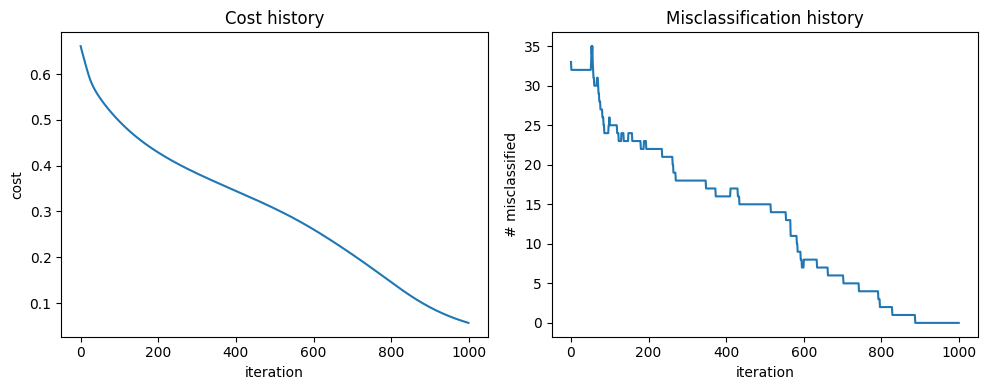

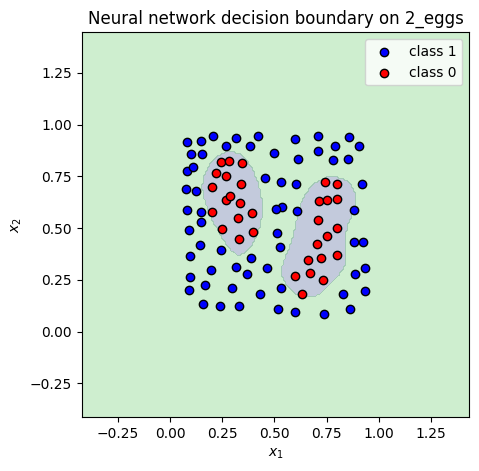

In [ ]:
data = np.loadtxt(datapath + '2_eggs.csv', delimiter=',')
x = data[:2, :]
y_raw = data[2, :]

# make y a row vector with 0/1 labels
if np.min(y_raw) < 0:
    y = (y_raw > 0).astype(float)[np.newaxis, :]
else:
    y = y_raw[np.newaxis, :].astype(float)

print("x shape:", x.shape)
print("y shape:", y.shape)

P = x.shape[1]

x_mean = np.mean(x, axis=1, keepdims=True)
x_std  = np.std(x, axis=1, keepdims=True) + 1e-8
x_norm = (x - x_mean) / x_std   # this is what we feed into the net

def activation(a):
    return np.tanh(a)

def feature_transforms(a, w_list):
    for W in w_list:
        a = W[0] + np.dot(a.T, W[1:])
        a = activation(a).T
    return a

def model(x_in, theta):
    hidden_weights = theta[0]
    final_weights  = theta[1]

    f = feature_transforms(x_in, hidden_weights)
    a = final_weights[0] + np.dot(f.T, final_weights[1:])
    return a.T

def network_initializer(layer_sizes, scale=0.5):
    weights = []
    for k in range(len(layer_sizes) - 1):
        U_k = layer_sizes[k]
        U_k_plus_1 = layer_sizes[k + 1]
        W = scale * np.random.randn(U_k + 1, U_k_plus_1)
        weights.append(W)

    theta_init = [weights[:-1], weights[-1]]
    return theta_init

def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def binary_cross_entropy_cost(theta, x_in, y):
    logits = model(x_in, theta)
    probs  = sigmoid(logits)
    eps = 1e-12
    probs = np.clip(probs, eps, 1.0 - eps)
    return -np.mean(y * np.log(probs) + (1.0 - y) * np.log(1.0 - probs))

def count_misclassifications(theta, x_in, y):
    logits = model(x_in, theta)
    probs  = sigmoid(logits)
    preds  = (probs >= 0.5).astype(float)
    return int(np.sum(preds != y))

np.random.seed(0)

N = x_norm.shape[0]
C = 1

# Example 13.4: 3 hidden layers, 10 units each
layer_sizes = [N, 10, 10, 10, C]

theta = network_initializer(layer_sizes, scale=0.5)

cost_grad = grad(binary_cross_entropy_cost, 0)

max_iters = 1000
alpha = 0.1

cost_history = []
mis_history  = []

best_theta = None
best_mis   = P + 1

for it in range(max_iters):
    g = cost_grad(theta, x_norm, y)

    # gradient step on hidden weights
    new_hidden = []
    for W, dW in zip(theta[0], g[0]):
        new_hidden.append(W - alpha * dW)

    # gradient step on final weights
    new_final = theta[1] - alpha * g[1]

    theta = [new_hidden, new_final]

    # evaluate
    c = binary_cross_entropy_cost(theta, x_norm, y)
    m = count_misclassifications(theta, x_norm, y)

    cost_history.append(c)
    mis_history.append(m)

    if m < best_mis:
        best_mis = m
        # deep copy of current theta
        best_theta = [
            [W.copy() for W in theta[0]],
            theta[1].copy()
        ]

print("\nBest # misclassified during training:", best_mis)
theta = best_theta   # use the best parameters we saw

plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(cost_history)
plt.xlabel("iteration")
plt.ylabel("cost")
plt.title("Cost history")

plt.subplot(1,2,2)
plt.plot(mis_history)
plt.xlabel("iteration")
plt.ylabel("# misclassified")
plt.title("Misclassification history")

plt.tight_layout()
plt.show()

grid_res = 200
x1_min, x1_max = x[0, :].min() - 0.5, x[0, :].max() + 0.5
x2_min, x2_max = x[1, :].min() - 0.5, x[1, :].max() + 0.5

xx1, xx2 = np.meshgrid(
    np.linspace(x1_min, x1_max, grid_res),
    np.linspace(x2_min, x2_max, grid_res)
)

grid = np.vstack([xx1.ravel(), xx2.ravel()])
grid_norm = (grid - x_mean) / x_std

grid_logits = model(grid_norm, theta)
grid_probs  = sigmoid(grid_logits)
grid_preds  = (grid_probs >= 0.5).astype(float).reshape(xx1.shape)

plt.figure(figsize=(5,5))
plt.contourf(xx1, xx2, grid_preds, levels=[-0.5, 0.5, 1.5], alpha=0.3)

y_flat = y.ravel()
plt.scatter(x[0, y_flat == 1], x[1, y_flat == 1],
            c='b', edgecolor='k', label='class 1')
plt.scatter(x[0, y_flat == 0], x[1, y_flat == 0],
            c='r', edgecolor='k', label='class 0')

plt.legend()
plt.title("Neural network decision boundary on 2_eggs")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

# Exercise 14.8. Random forests

In [ ]:
csvname = datapath + 'new_circle_data.csv'

data = np.loadtxt(csvname, delimiter = ',')
x = data[:-1,:]
y = data[-1,:]

print(np.shape(x))
print(np.shape(y))

# put inputs in (P, 2) form
X = x.T
y = y.astype(float)
P, N = X.shape

def gini_impurity(y_subset):
    if len(y_subset) == 0:
        return 0.0
    ignore, counts = np.unique(y_subset, return_counts=True)
    p = counts / len(y_subset)
    return 1.0 - np.sum(p**2)


def majority_label(y_subset):
    labels, counts = np.unique(y_subset, return_counts=True)
    return labels[np.argmax(counts)]

class TreeNode:
    def __init__(self, is_leaf, prediction=None,
                 feature=None, threshold=None,
                 left=None, right=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right


def build_tree(X, y, max_depth, min_samples_leaf=1, depth=0, rng=None):
    if rng is None:
        rng = np.random.RandomState()

    num_samples, num_features = X.shape

    # stopping conditions
    if (depth >= max_depth or
        num_samples <= min_samples_leaf or
        len(np.unique(y)) == 1):
        return TreeNode(is_leaf=True, prediction=majority_label(y))

    # choose random subset of features: floor(sqrt(N)) as in RF
    m_try = max(1, int(np.sqrt(num_features)))
    feature_indices = rng.choice(num_features, size=m_try, replace=False)

    best_feature = None
    best_threshold = None
    best_impurity = np.inf
    best_left_index = None
    best_right_index = None

    # search over candidate splits
    for feat in feature_indices:
        # sort data by this feature
        order = np.argsort(X[:, feat])
        Xf = X[order, feat]
        yf = y[order]

        # candidate thresholds: midpoints between distinct values
        for i in range(1, num_samples):
            if Xf[i] == Xf[i - 1]:
                continue
            threshold = 0.5 * (Xf[i] + Xf[i - 1])

            left_mask = X[:, feat] <= threshold
            right_mask = ~left_mask

            if (left_mask.sum() < min_samples_leaf or
                right_mask.sum() < min_samples_leaf):
                continue

            y_left = y[left_mask]
            y_right = y[right_mask]

            impurity = (len(y_left) * gini_impurity(y_left) +
                        len(y_right) * gini_impurity(y_right)) / num_samples

            if impurity < best_impurity:
                best_impurity = impurity
                best_feature = feat
                best_threshold = threshold
                best_left_index = left_mask
                best_right_index = right_mask

    # if no valid split found, make leaf
    if best_feature is None:
        return TreeNode(is_leaf=True, prediction=majority_label(y))

    # recurse on children
    left_node = build_tree(X[best_left_index],
                           y[best_left_index],
                           max_depth=max_depth,
                           min_samples_leaf=min_samples_leaf,
                           depth=depth + 1,
                           rng=rng)

    right_node = build_tree(X[best_right_index],
                            y[best_right_index],
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            depth=depth + 1,
                            rng=rng)

    return TreeNode(is_leaf=False,
                    feature=best_feature,
                    threshold=best_threshold,
                    left=left_node,
                    right=right_node)


def tree_predict(tree, X):
    preds = []
    for x in X:
        node = tree
        while not node.is_leaf:
            if x[node.feature] <= node.threshold:
                node = node.left
            else:
                node = node.right
        preds.append(node.prediction)
    return np.array(preds)

rng = np.random.RandomState(0)

index = rng.permutation(P)
test_size = P // 3
test_index = index[:test_size]
train_index = index[test_size:]

X_train, y_train = X[train_index], y[train_index]
X_test, y_test = X[test_index], y[test_index]

num_trees = 5
max_depth = 7
min_samples_leaf = 1

trees = []
indiv_accuracies = []

for m in range(num_trees):
    # bootstrap sample from training set
    boot_index = rng.choice(len(X_train),
                          size=len(X_train),
                          replace=True)
    X_boot = X_train[boot_index]
    y_boot = y_train[boot_index]

    tree = build_tree(X_boot, y_boot,
                      max_depth=max_depth,
                      min_samples_leaf=min_samples_leaf,
                      rng=rng)
    trees.append(tree)

    # evaluate this tree on test set
    preds = tree_predict(tree, X_test)
    acc = float(np.mean(preds == y_test))
    indiv_accuracies.append(acc)
    print(f"Tree {m+1}: test accuracy = {acc:.3f}")

all_preds = np.array([tree_predict(t, X_test) for t in trees])  # (num_trees, n_test)

bagged_preds = []
for j in range(all_preds.shape[1]):
    col = all_preds[:, j]
    labels, counts = np.unique(col, return_counts=True)
    bagged_preds.append(labels[np.argmax(counts)])
bagged_preds = np.array(bagged_preds)

forest_acc = np.mean(bagged_preds == y_test)
print("\nRandom forest accuracy on test set:", forest_acc)
print("Individual tree accuracies:", indiv_accuracies)

(2, 99)
(99,)
Tree 1: test accuracy = 0.727
Tree 2: test accuracy = 0.727
Tree 3: test accuracy = 0.788
Tree 4: test accuracy = 0.879
Tree 5: test accuracy = 0.939

Random forest accuracy on test set: 0.9090909090909091
Individual tree accuracies: [0.7272727272727273, 0.7272727272727273, 0.7878787878787878, 0.8787878787878788, 0.9393939393939394]


# Exercise 8.8. Perform K-Means

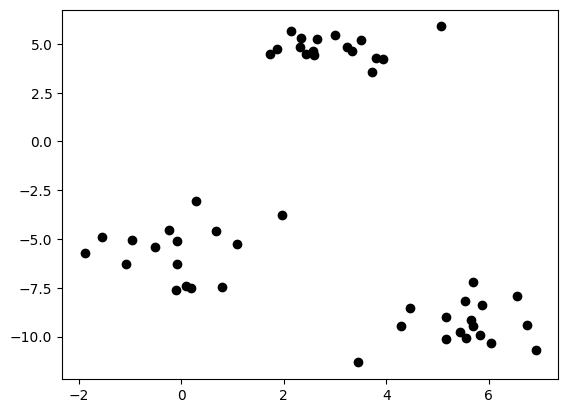

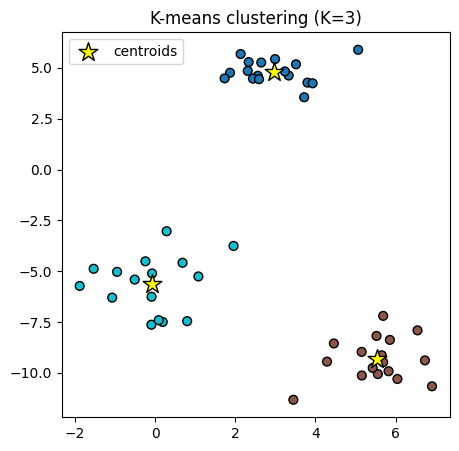

In [ ]:
import matplotlib.pyplot as plt
from sklearn import datasets

# Loading the data
P = 50
blobs = datasets.make_blobs(n_samples=P,centers = 3,random_state=10)
data = np.transpose(blobs[0])

# scatter plot the dataset
plt.scatter(data[0,:],data[1,:],c = 'k')
plt.show()

X = data.T

def init_centroids(X, K, rng=None):
    if rng is None:
        rng = np.random.RandomState()
    index = rng.choice(X.shape[0], size=K, replace=False)
    return X[index].copy()

def assign_clusters(X, centroids):
    dists = np.linalg.norm(X[:, np.newaxis, :] - centroids[np.newaxis, :, :], axis=2)
    return np.argmin(dists, axis=1)

def update_centroids(X, labels, K):
    centroids = []
    for k in range(K):
        cluster_points = X[labels == k]
        if len(cluster_points) == 0:
            # if a cluster ended up empty, just re-pick a random point
            centroids.append(X[np.random.randint(0, X.shape[0])])
        else:
            centroids.append(cluster_points.mean(axis=0))
    return np.vstack(centroids)

def kmeans(X, K, max_iters=50, tol=1e-4, seed=0):
    rng = np.random.RandomState(seed)
    centroids = init_centroids(X, K, rng)

    for it in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, K)

        # check movement of centroids
        shift = np.linalg.norm(new_centroids - centroids)
        centroids = new_centroids
        if shift < tol:
            break

    return centroids, labels

K = 3
centroids, labels = kmeans(X, K, max_iters=100, tol=1e-4, seed=0)

# average intra-cluster distance
centroids_for_points = centroids[labels]
intra_dists = np.linalg.norm(X - centroids_for_points, axis=1)
avg_intra = np.mean(intra_dists)

plt.figure(figsize=(5, 5))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=40, edgecolor='k')
plt.scatter(centroids[:, 0], centroids[:, 1],
            c='yellow', s=200, marker='*', edgecolor='k', label='centroids')
plt.title("K-means clustering (K=3)")
plt.legend()
plt.show()